# Final Project - Deep Learning
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Noam Pdut (ID. 315097113)
<br>
Student 2: Rotem Ghidale (ID. 211914668)


### Goodluck!

#Data

### Download the data

In [ ]:
! pip install -q kaggle

In [ ]:

from google.colab import files

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"rotemg","key":"b6562738d598cd963cf6805bf7f79b51"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download -c gan-getting-started
! mkdir dataset
! unzip gan-getting-started.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/photo_jpg/46e71a4094.jpg  
  inflating: dataset/photo_jpg/46e84039a1.jpg  
  inflating: dataset/photo_jpg/46f391abec.jpg  
  inflating: dataset/photo_jpg/46f5ef1042.jpg  
  inflating: dataset/photo_jpg/4706619607.jpg  
  inflating: dataset/photo_jpg/4707b03a08.jpg  
  inflating: dataset/photo_jpg/47100a9939.jpg  
  inflating: dataset/photo_jpg/471f4755b9.jpg  
  inflating: dataset/photo_jpg/472b351bc4.jpg  
  inflating: dataset/photo_jpg/472d5ac100.jpg  
  inflating: dataset/photo_jpg/4758e5dd4c.jpg  
  inflating: dataset/photo_jpg/4762bb79ef.jpg  
  inflating: dataset/photo_jpg/4778b13518.jpg  
  inflating: dataset/photo_jpg/4787b82d37.jpg  
  inflating: dataset/photo_jpg/478e07feaa.jpg  
  inflating: dataset/photo_jpg/478eb12a82.jpg  
  inflating: dataset/photo_jpg/479698b371.jpg  
  inflating: dataset/photo_jpg/4796d67f61.jpg  
  inflating: dataset/photo_jpg/47aad493bd.jpg  
  inflating: dataset/photo_jpg/47ae0e

In [ ]:
import tensorflow as tf
import re
GCS_PATH = "dataset"

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


Monet TFRecord Files: 5
Photo TFRecord Files: 20


#First Model - CycalGan

###Preprocess the data

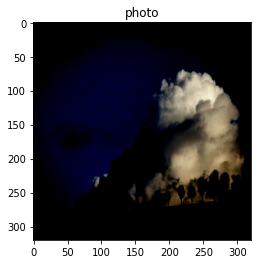

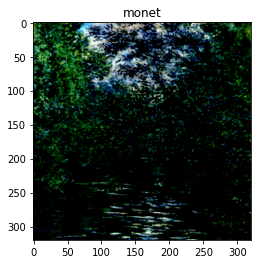

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

IMG_SIZE = [256, 256]

def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


def reformat_img(example):
    tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    img = example['image']

    img = tf.image.decode_jpeg(img, channels=3)
    img = normalize(img)
    img = tf.reshape(img, [*IMG_SIZE, 3])
    img = tf.image.resize(img, [320,320])
    return img

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(reformat_img)
    return dataset


# Split photo and monet datasets into training and testing sets
photo_train, photo_test = train_test_split(PHOTO_FILENAMES, test_size=0.2, random_state=42)
monet_train, monet_test = train_test_split(MONET_FILENAMES, test_size=0.2, random_state=42)


# Create TensorFlow datasets from the training and testing sets
photo_train_ds = load_dataset(photo_train).batch(1)
photo_test_ds = load_dataset(photo_test).batch(1)

monet_train_ds = load_dataset(monet_train).batch(1)
monet_test_ds = load_dataset(monet_test).batch(1)


monet_pic = next(iter(monet_train_ds))
photo_pic = next(iter(photo_train_ds))

plt.title('photo')
plt.imshow(photo_pic[0])
plt.show()

plt.title('monet')
plt.imshow(monet_pic[0])
plt.show()




##Build generator and discriminator

In [ ]:
! pip install tensorflow.keras
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    layer = lambda filters, size : keras.Sequential([ layers.Conv2D(filters, size, strides=2, padding='same',
                                                                    kernel_initializer=init, use_bias=False),
                                                     tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), layers.LeakyReLU()]);

    inp = layers.Input(shape=[320, 320, 3], name='input_image')

    first = keras.Sequential([layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init, use_bias=False), layers.LeakyReLU()])

    x = layer(256, 4)(layer(128, 4)(first(inp)))
    padding = layers.ZeroPadding2D()(x)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(padding)

    leaky_relu = layers.LeakyReLU()(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv))

    out = layers.Conv2D(1, 4, strides=1,kernel_initializer=init)(layers.ZeroPadding2D()(leaky_relu))

    dis_model = tf.keras.Model(inputs=inp, outputs=out)

    return dis_model


def build_generator():
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    layer1 = lambda filters, size : keras.Sequential([
                                                    layers.Conv2D(filters, size, strides=2, padding='same',
                                                                      kernel_initializer=init, use_bias=False),
                                                     tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), layers.LeakyReLU()]);

    layer2_no_drop = lambda filters, size : keras.Sequential([
                                      layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                                                      kernel_initializer=init,use_bias=False),
                                      tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
                                      layers.ReLU()])


    layer2_with_drop = lambda filters, size : keras.Sequential([
                                        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                                                      kernel_initializer=init, use_bias=False),
                                        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
                                        layers.Dropout(0.5),
                                        layers.ReLU()])

    inp = layers.Input(shape=[320,320,3])
    x = layers.Lambda(lambda image: tf.image.resize(image, (256, 256)))(inp)

    first = keras.Sequential([layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init, use_bias=False), layers.LeakyReLU()])


    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh')

    new_last = layers.Conv2DTranspose(3, 4, strides=1, padding='same', kernel_initializer=init, activation='tanh')
    last2 = layers.Lambda(lambda image: tf.image.resize(image, (320, 320)))

    tmp = x

    lst1 = [
        first,
        layer1(128, 4),
        layer1(256, 4),
        layer1(512, 4),
        layer1(512, 4),
        layer1(512, 4),
        layer1(512, 4),
        layer1(512, 4),
    ]

    lst2 = [
        layer2_with_drop(512, 4),
        layer2_with_drop(512, 4),
        layer2_with_drop(512, 4),
        layer2_no_drop(512, 4),
        layer2_no_drop(256, 4),
        layer2_no_drop(128, 4),
        layer2_no_drop(64, 4),
    ]

    lst_skip_connections = []
    for layer_itm in lst1:
        tmp = layer_itm(tmp)
        lst_skip_connections.append(tmp)

    lst_skip_connections = reversed(lst_skip_connections[:-1])

    # build the skip connections
    for layer_itm, connection_skip in zip(lst2, lst_skip_connections):
        tmp = layer_itm(tmp)
        tmp = layers.Concatenate()([tmp, connection_skip])

    out = last(tmp)
    out = last2(out)
    return keras.Model(inputs=inp, outputs=out)

##Train the model

In [ ]:

# Create the generator and discriminator
generator_photo = build_generator()
generator_monet = build_generator()
discriminator_photo = build_discriminator()
discriminator_monet = build_discriminator()

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l1_loss = tf.keras.losses.MeanAbsoluteError()

# Define the optimizers

generator_optimizer_photo = tf.keras.optimizers.SGD(0.01, momentum=0.5)
discriminator_optimizer_photo = tf.keras.optimizers.SGD(0.01, momentum=0.5)

generator_optimizer_monet = tf.keras.optimizers.SGD(0.01, momentum=0.5)
discriminator_optimizer_monet = tf.keras.optimizers.SGD(0.01, momentum=0.5)

# Define loss function
def generator_loss(fake_output): #, fake_monet, photo):
    entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    return entropy

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss)* 0.6

def identity_loss(real_image, same_image):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return  10 * 0.5 * loss

def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:

        # photo to monet back to photo
        fake_monet = generator_monet(real_photo, training=True)
        cycled_photo = generator_photo(fake_monet, training=True)

        # monet to photo back to monet
        fake_photo = generator_photo(real_monet, training=True)
        cycled_monet = generator_monet(fake_photo, training=True)

        # generating itself
        same_monet = generator_monet(real_monet, training=True)
        same_photo = generator_photo(real_photo, training=True)

        # discriminator used to check, inputing real images
        disc_real_monet = discriminator_monet(real_monet, training=True)
        disc_real_photo = discriminator_photo(real_photo, training=True)

        # discriminator used to check, inputing fake images
        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)

        # evaluates generator loss
        monet_gen_loss = generator_loss(disc_fake_monet)
        photo_gen_loss = generator_loss(disc_fake_photo)

        # evaluates total cycle consistency loss
        total_cycle_loss = calc_cycle_loss(real_monet, cycled_monet) + calc_cycle_loss(real_photo, cycled_photo)

        # evaluates total generator loss
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)

        # evaluates discriminator loss
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate the gradients for generator and discriminator
    monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                              generator_monet.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                              generator_photo.trainable_variables)

    monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                  discriminator_monet.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                  discriminator_photo.trainable_variables)

    # Apply the gradients to the optimizer
    generator_optimizer_monet.apply_gradients(zip(monet_generator_gradients,
                                              generator_monet.trainable_variables))

    generator_optimizer_photo.apply_gradients(zip(photo_generator_gradients,
                                              generator_photo.trainable_variables))

    discriminator_optimizer_monet.apply_gradients(zip(monet_discriminator_gradients,
                                              discriminator_monet.trainable_variables))

    discriminator_optimizer_photo.apply_gradients(zip(photo_discriminator_gradients,
                                              discriminator_photo.trainable_variables))

    return {
          "monet_gen_loss": total_monet_gen_loss,
          "photo_gen_loss": total_photo_gen_loss,
          "monet_disc_loss": monet_disc_loss,
          "photo_disc_loss": photo_disc_loss }

# Define the training loop
def fit(train_ds_photo, train_ds_monet, epochs, test_ds_photo, test_ds_monet):
    for epoch in range(epochs):
        # Train the model on each batch in the training dataset
        for photo, monet in zip(train_ds_photo, train_ds_monet):
            loss = train_step(photo, monet)

        loss_monet_gen_list.append(loss['monet_gen_loss'])
        loss_monet_disc_list.append(loss['monet_disc_loss'])

        loss_photo_gen_list.append(loss['photo_gen_loss'])
        loss_photo_disc_list.append(loss['photo_disc_loss'])

        # Print the generator and discriminator loss for each epoch
        print(f"Epoch {epoch+1} Generator Loss monet: {loss['monet_gen_loss']:.4f}, Discriminator Loss monet: {loss['monet_disc_loss']:.4f}, Generator Loss photo: {loss['photo_gen_loss']:.4f}, Discriminator Loss photo: {loss['photo_disc_loss']:.4f}")


# Train the model
epochs = 20
epoch_list = [i for i in range(1,epochs+1)]
loss_monet_gen_list = []
loss_photo_gen_list = []

loss_monet_disc_list = []
loss_photo_disc_list = []

fit(photo_train_ds,monet_train_ds.take(30), epochs, photo_test_ds, monet_test_ds)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1 Generator Loss monet: 5.1758, Discriminator Loss monet: 0.8317, Generator Loss photo: 4.8837, Discriminator Loss photo: 0.8316
Epoch 2 Generator Loss monet: 4.9468, Discriminator Loss monet: 0.8315, Generator Loss photo: 4.5894, Discriminator Loss photo: 0.8313
Epoch 3 Generator Loss monet: 4.1194, Discriminator Loss monet: 0.8316, Generator Loss photo: 3.7295, Discriminator Loss photo: 0.8316
Epoch 4 Generator Loss monet: 4.1454, Discriminator Loss monet: 0.8315, Generator Loss photo: 3.7511, Discriminator Loss photo: 0.8314
Epoch 5 Generator Loss monet: 4.1160, Discriminator Loss monet: 0.8315, Generator Loss photo: 3.7317, Discriminator Loss photo: 0.8313
Epoch 6 Generator Loss monet: 4.0755, Discriminator Loss monet: 0.8314, Generator Loss photo: 3.7064, Discriminator Loss photo: 0.8312
Epoch 7 Generator Loss monet: 4.0235, Discriminator Loss monet: 0.8314, Generator Loss photo: 3.6673, Discriminator Loss photo: 0.8311
Epoch 8 Generator Loss monet: 3.9229, Discriminator Los

##Experiments on the model
The parameters we tested and did the experiments on are:

1.   number of epochs
2.   optimizer type
3. learning rate


####Experiment 1

1.   <b>epochs:</b> 20
2.   <b>optimizer:</b> SGD with momentum
3.   <b>lr:</b> 0.01


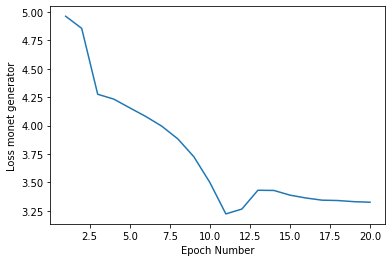

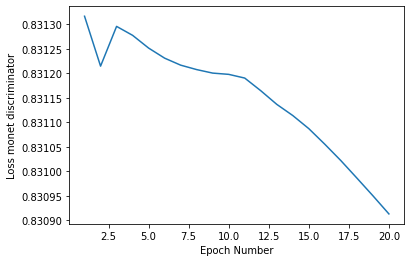

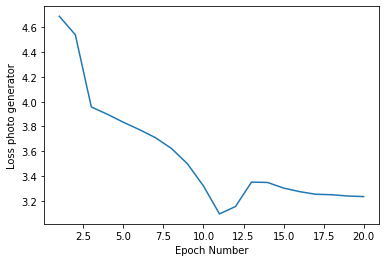

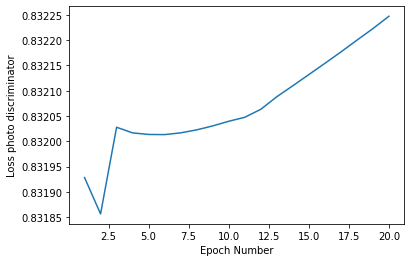

In [ ]:
#for 20 epochs, tf.keras.optimizers.SGD(0.01, momentum=0.5)
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss monet generator")
plt.plot(epoch_list, loss_monet_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss monet discriminator")
plt.plot(epoch_list, loss_monet_disc_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo generator")
plt.plot(epoch_list, loss_photo_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo discriminator")
plt.plot(epoch_list, loss_photo_disc_list)
plt.show()

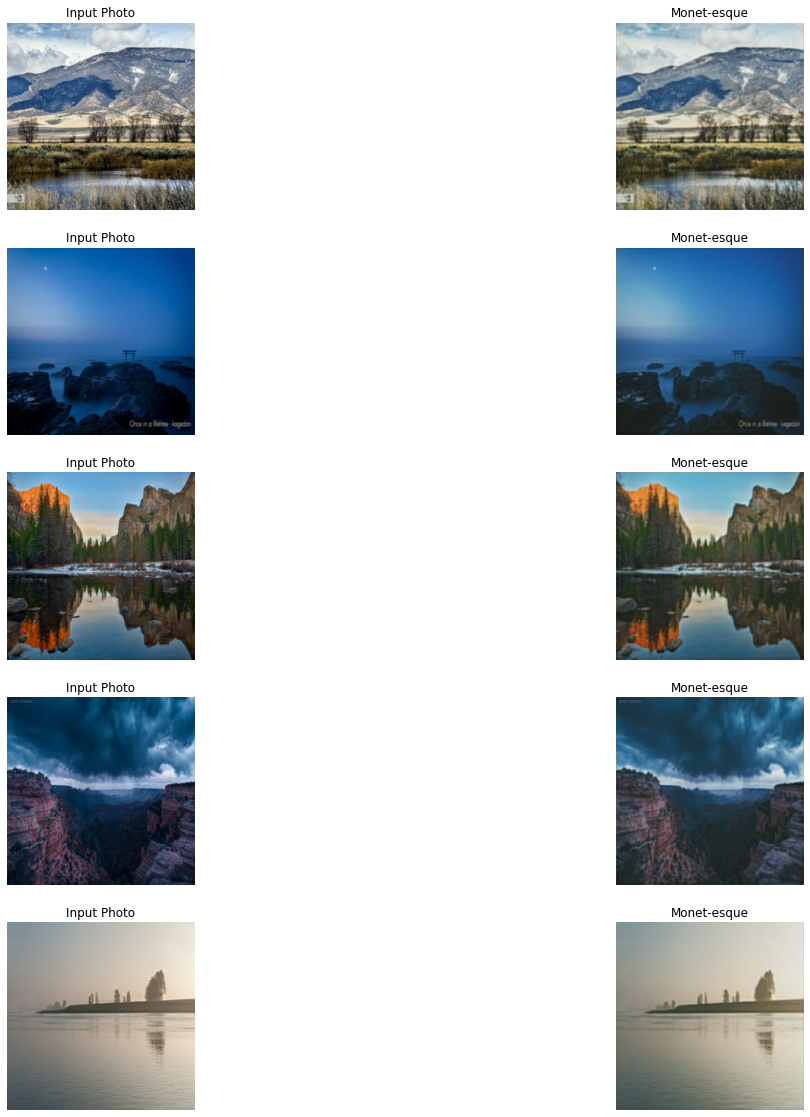

In [ ]:
#for 20 epochs, tf.keras.optimizers.SGD(0.01, momentum=0.5)
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_test_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

####Experiment 2

1.   <b>epochs:</b> 20
2.   <b>optimizer:</b> SGD with momentum
3.   <b>lr:</b> 0.002

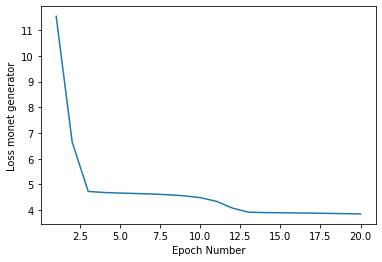

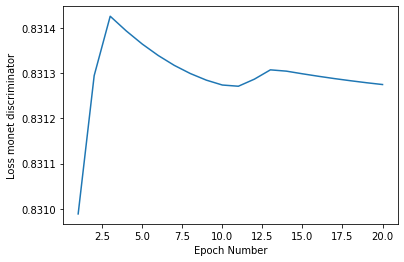

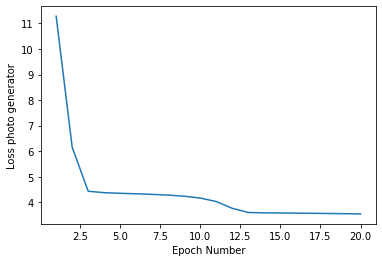

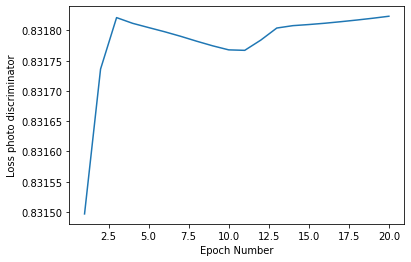

In [ ]:
#for 20 epochs, tf.keras.optimizers.SGD(0.002, momentum=0.5)
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss monet generator")
plt.plot(epoch_list, loss_monet_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss monet discriminator")
plt.plot(epoch_list, loss_monet_disc_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo generator")
plt.plot(epoch_list, loss_photo_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo discriminator")
plt.plot(epoch_list, loss_photo_disc_list)
plt.show()

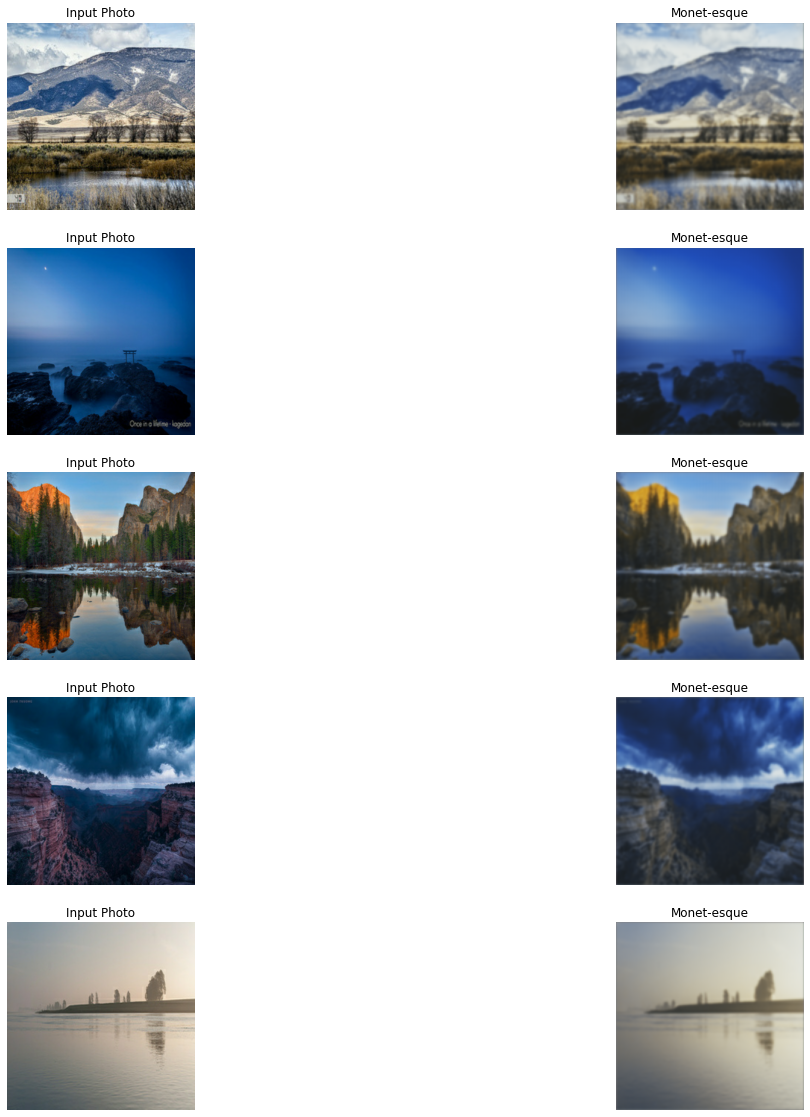

In [ ]:
#for 20 epochs, tf.keras.optimizers.SGD(0.002, momentum=0.5)
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_test_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

####Experiment 3

1.   <b>epochs:</b> 20
2.   <b>optimizer:</b> Adam
3.   <b>lr:</b> 0.01

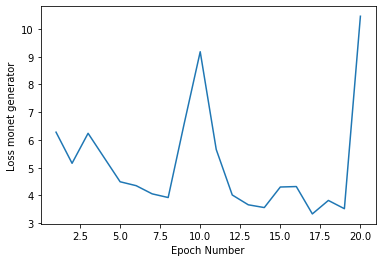

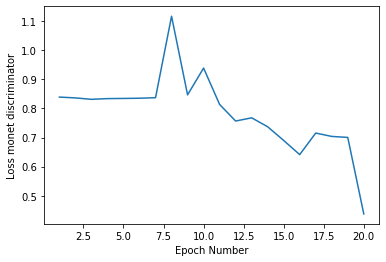

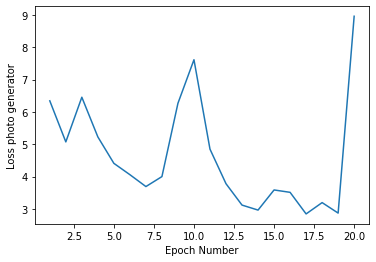

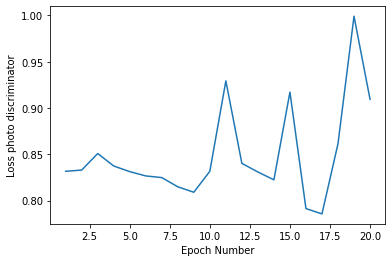

In [ ]:
#for 20 epochs, tf.keras.optimizers.Adam(0.01, beta_1=0.5)
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss monet generator")
plt.plot(epoch_list, loss_monet_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss monet discriminator")
plt.plot(epoch_list, loss_monet_disc_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo generator")
plt.plot(epoch_list, loss_photo_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo discriminator")
plt.plot(epoch_list, loss_photo_disc_list)
plt.show()

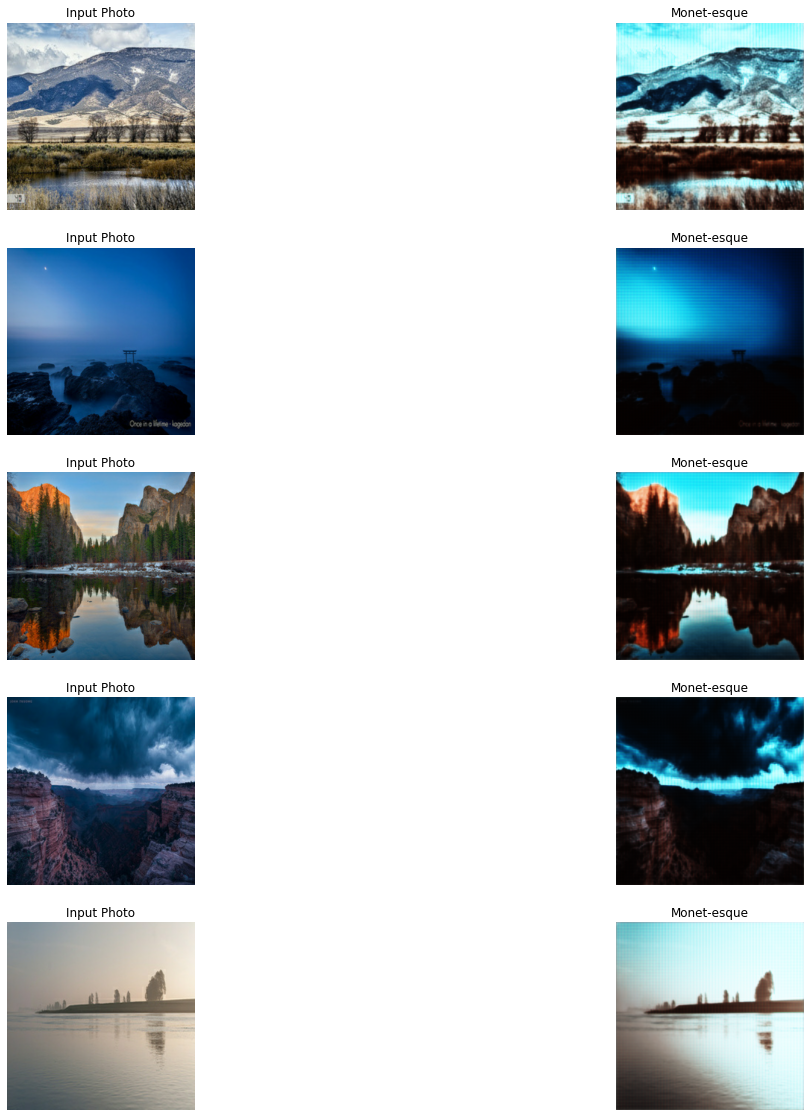

In [ ]:
#for 20 epochs, tf.keras.optimizers.Adam(0.01, beta_1=0.5)
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_test_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

####Experiment 4

1.   <b>epochs:</b> 20
2.   <b>optimizer:</b> Adam
3.   <b>lr:</b> 0.0002

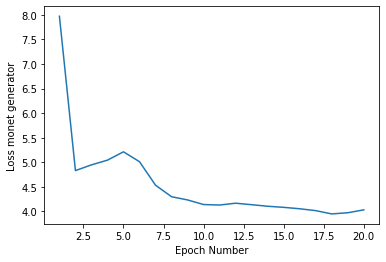

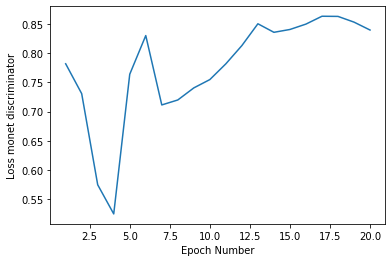

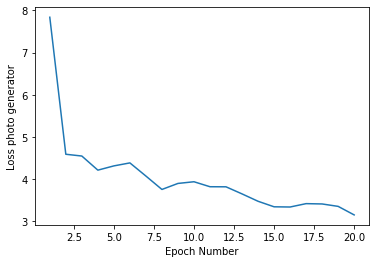

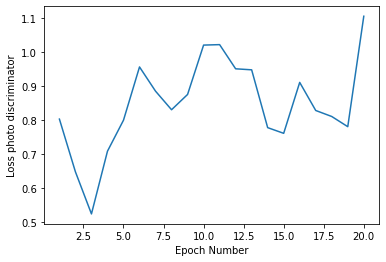

In [ ]:
#for 20 epochs, tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss monet generator")
plt.plot(epoch_list, loss_monet_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss monet discriminator")
plt.plot(epoch_list, loss_monet_disc_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo generator")
plt.plot(epoch_list, loss_photo_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo discriminator")
plt.plot(epoch_list, loss_photo_disc_list)
plt.show()

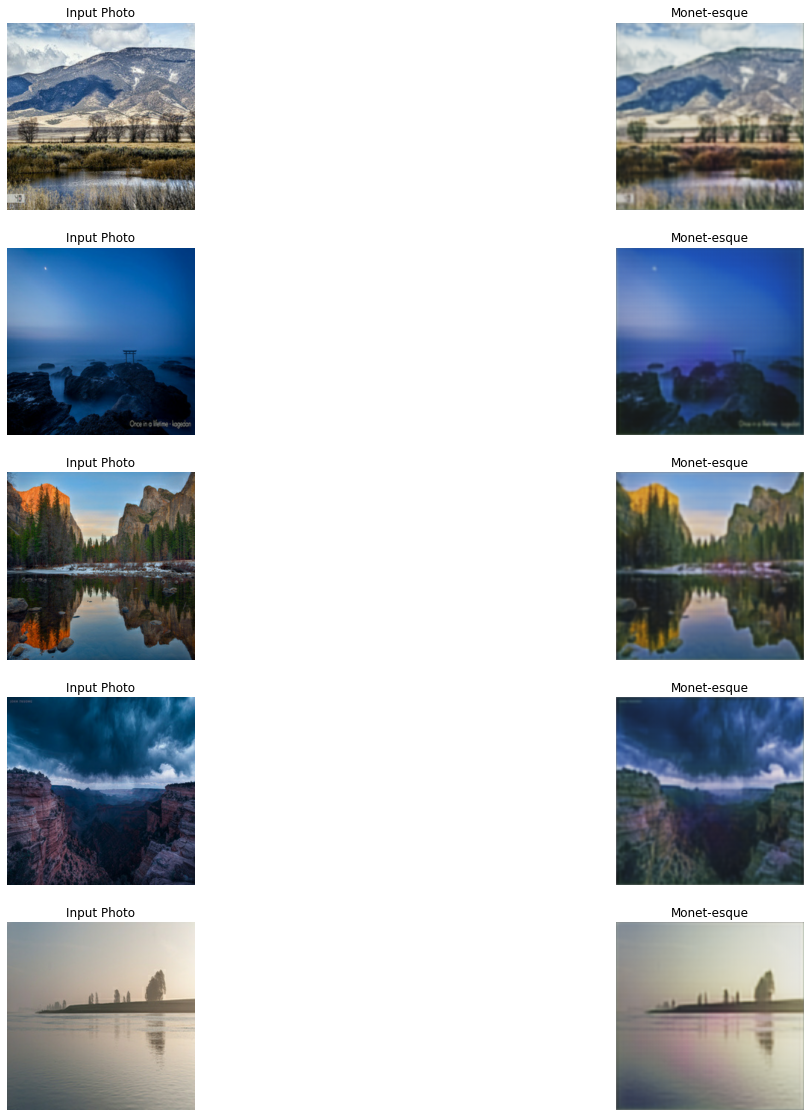

In [ ]:
#for 20 epochs, tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_test_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

####Experiment 5

1.   <b>epochs:</b> 5
2.   <b>optimizer:</b> Adam
3.   <b>lr:</b> 0.0002

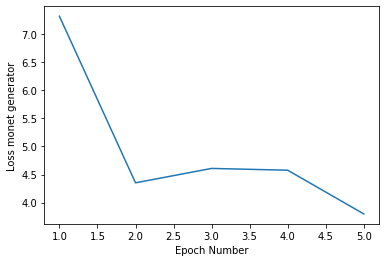

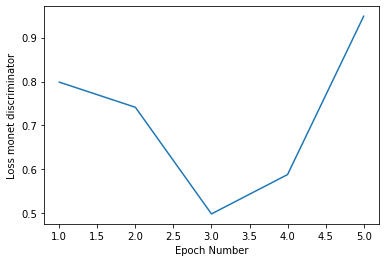

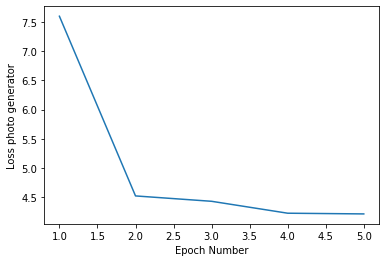

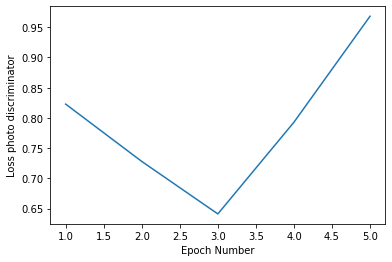

In [ ]:
#for 5 epochs, tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss monet generator")
plt.plot(epoch_list, loss_monet_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss monet discriminator")
plt.plot(epoch_list, loss_monet_disc_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo generator")
plt.plot(epoch_list, loss_photo_gen_list)
plt.show()

plt.xlabel('Epoch Number')
plt.ylabel("Loss photo discriminator")
plt.plot(epoch_list, loss_photo_disc_list)
plt.show()

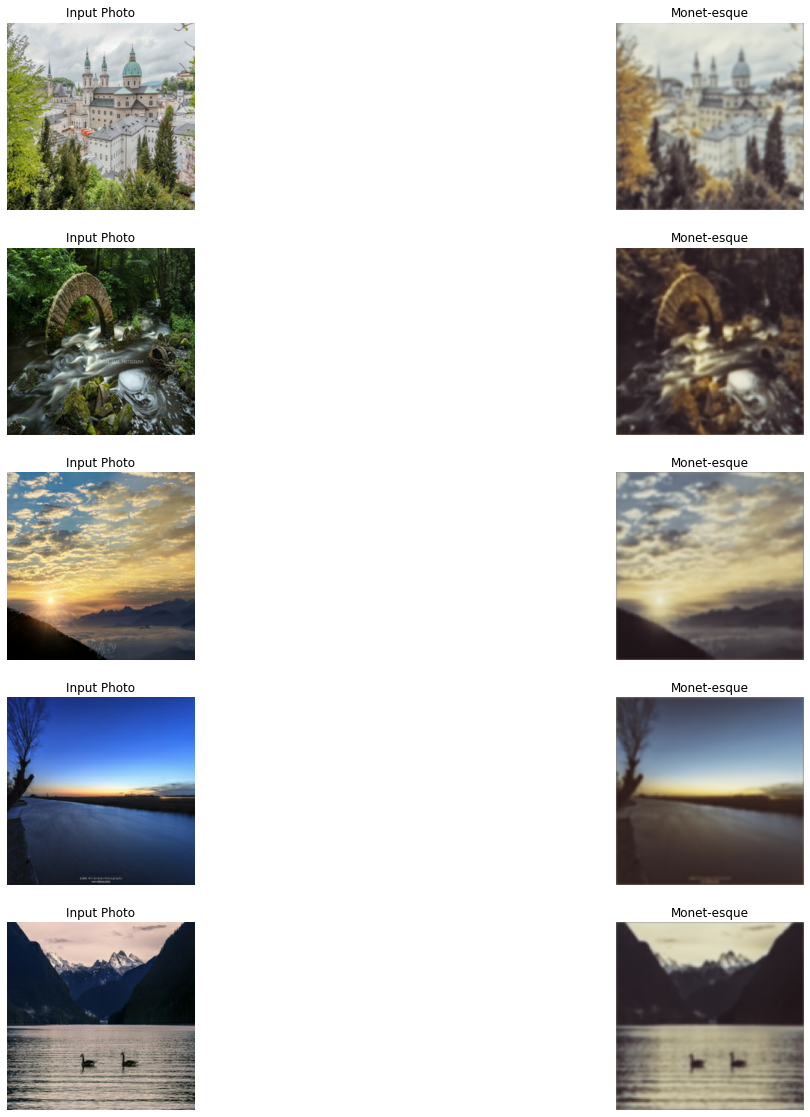

In [ ]:
#for 5 epochs, tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_test_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

##Save the model

In [ ]:
generator_monet.save('generator_monet_model')

In [ ]:
!zip -r generator_monet_model.zip generator_monet_model

files.download("generator_monet_model.zip")

  adding: generator_monet_model/ (stored 0%)
  adding: generator_monet_model/fingerprint.pb (stored 0%)
  adding: generator_monet_model/assets/ (stored 0%)
  adding: generator_monet_model/variables/ (stored 0%)
  adding: generator_monet_model/variables/variables.index (deflated 68%)
  adding: generator_monet_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: generator_monet_model/saved_model.pb (deflated 92%)
  adding: generator_monet_model/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Second Model - VGG

##Preprocess the data

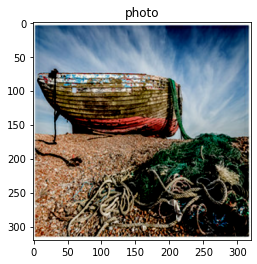

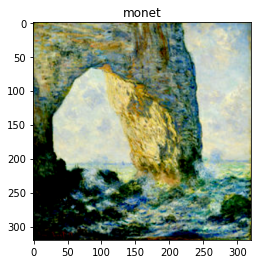

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

IMG_SIZE = [256, 256]

def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  gamma = 0.5
  image = tf.pow((image + 1) / 2, gamma) * 2 - 1

  return image


def reformat_img(example):
    tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    img = example['image']

    img = tf.image.decode_jpeg(img, channels=3)
    img = normalize(img)
    img = tf.reshape(img, [*IMG_SIZE, 3])
    img = tf.image.resize(img, [320,320])
    return img

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(reformat_img)
    return dataset


# Split photo and monet datasets into training and testing sets
photo_train, photo_test = train_test_split(PHOTO_FILENAMES, test_size=0.2, random_state=42)
monet_train, monet_test = train_test_split(MONET_FILENAMES, test_size=0.2, random_state=42)


# Create TensorFlow datasets from the training and testing sets
photo_train_ds = load_dataset(photo_train).batch(1)
photo_test_ds = load_dataset(photo_test).batch(1)

monet_train_ds = load_dataset(monet_train).batch(1)
monet_test_ds = load_dataset(monet_test).batch(1)


monet_pic = next(iter(monet_train_ds))
photo_pic = next(iter(photo_train_ds))

plt.title('photo')
plt.imshow(photo_pic[0])
plt.show()

plt.title('monet')
plt.imshow(monet_pic[0])
plt.show()



##The Model

In [ ]:
import numpy as np
#create the second model architectur

# for loss visualization
epoch_list = []
loss_list = []

class VGGModel():

  def __init__(self):
    # Define the neural network
    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # Define the content and style layers
    self.content_layers = ['block5_conv2']
    self.style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # Define the intermediate models
    self.content_model = tf.keras.models.Model(inputs=self.vgg.input, outputs=[self.vgg.get_layer(layer).output for layer in self.content_layers])
    self.style_model = tf.keras.models.Model(inputs=self.vgg.input, outputs=[self.vgg.get_layer(layer).output for layer in self.style_layers])

    # Define the number of iterations and the weights for the loss components
    self.num_iterations = 500
    self.content_weight = 1e4
    self.style_weight = 1e-2
    self.variation_weight = 1e-3

    self.style_image = None

  def gram_matrix(self, input_tensor):
      # Flatten the feature maps
      channels = int(input_tensor.shape[-1])
      a = tf.reshape(input_tensor, [-1, channels])

      # Compute the Gram matrix
      n = tf.shape(a)[0]
      gram = tf.matmul(a, a, transpose_a=True) / tf.cast(n, tf.float32)

      return gram

  def content_loss(self, content, target):
      return tf.reduce_mean(tf.square(content - target))

  def style_loss(self, style, target):
      style_gram = self.gram_matrix(style)
      target_gram = self.gram_matrix(target)
      return tf.reduce_mean(tf.square(style_gram - target_gram))

  def total_variation_loss(self, image):
      x_var = tf.reduce_mean(tf.square(image[:, :, :-1, :] - image[:, :, 1:, :]))
      y_var = tf.reduce_mean(tf.square(image[:, :-1, :, :] - image[:, 1:, :, :]))
      return x_var + y_var

  def train(self, monet_ds):
    for m in monet_ds.take(1):
      self.style_image = m

  def generate(self, content_image, loss_visualize = False):
    optimizer = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.99, epsilon=1e-1)

    # Define the initial generated image
    generated_image = tf.Variable(content_image)

    for i in range(self.num_iterations):
      with tf.GradientTape() as tape:
          # Compute the content loss
          content_features = self.content_model(content_image)
          generated_features = self.content_model(generated_image)
          c_loss = self.content_loss(content_features[0], generated_features[0])

          # Compute the style loss
          style_features = self.style_model(self.style_image)
          generated_features = self.style_model(generated_image)
          s_loss = 0
          for j in range(len(self.style_layers)):
              s_loss += self.style_loss(style_features[j], generated_features[j])
          s_loss /= len(self.style_layers)

          # Compute the total variation loss
          v_loss = self.total_variation_loss(generated_image)

          # Compute the total loss
          total_loss = self.content_weight * c_loss + self.style_weight * s_loss + self.variation_weight * v_loss

      # Compute the gradients and update the generated image
      gradients = tape.gradient(total_loss, generated_image)
      optimizer.apply_gradients([(gradients, generated_image)])

      # Clip the pixel values to the range [0, 255]
      generated_image.assign(tf.clip_by_value(generated_image, 0, 255))

      # Print the loss and save it to diplay later
      if loss_visualize:
        print("Iteration: {}, Total loss: {}".format(i+1, total_loss))
        epoch_list.append(i+1)
        loss_list.append(total_loss)

    return generated_image

##Experiments on the model
The parameters we tested and did the experiments on are:

1.   number of epochs
2.   optimizer type
3. learning rate




###Experiment 1

1.   <b>epochs:</b> 5
2.   <b>optimizer:</b> Adam
3. <b>lr:</b> 0.02



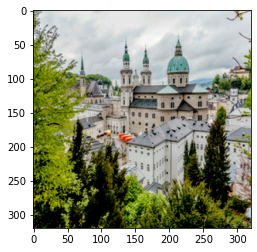

Iteration: 1, Total loss: 9.285735130310059
Iteration: 2, Total loss: 1201.4764404296875
Iteration: 3, Total loss: 980.9678344726562
Iteration: 4, Total loss: 797.1243896484375
Iteration: 5, Total loss: 677.976318359375


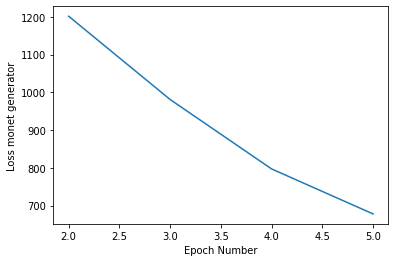

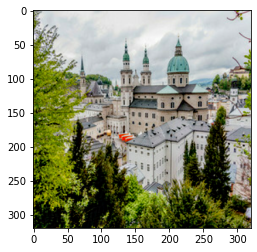

In [ ]:
#for 5 epochs with adam with lr=0.02
import numpy as np
model = VGGModel()
model.train(monet_train_ds)

import matplotlib.pyplot as plt
def visual_loss():
  plt.xlabel('Epoch Number')
  plt.ylabel("Loss monet generator")
  plt.plot(epoch_list[1:], loss_list[1:])
  plt.show()

for i, img in enumerate(photo_test_ds.take(1)):
    plt.imshow(img[0])
    plt.show()
    prediction = model.generate(img, True)[0].numpy()

    visual_loss()
    plt.imshow(prediction)
    plt.show()

###Experiment 2

1.   <b>epochs:</b> 500
2.   <b>optimizer:</b> Adam
3. <b>lr:</b> 0.02


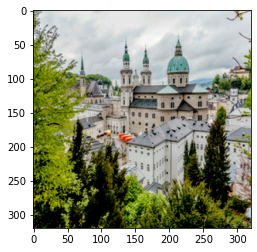

Iteration: 1, Total loss: 9.285735130310059
Iteration: 2, Total loss: 1201.4764404296875
Iteration: 3, Total loss: 980.9678344726562
Iteration: 4, Total loss: 797.1244506835938
Iteration: 5, Total loss: 677.976318359375
Iteration: 6, Total loss: 595.8107299804688
Iteration: 7, Total loss: 536.7393188476562
Iteration: 8, Total loss: 490.67327880859375
Iteration: 9, Total loss: 453.7994384765625
Iteration: 10, Total loss: 423.53887939453125
Iteration: 11, Total loss: 399.7251281738281
Iteration: 12, Total loss: 380.648681640625
Iteration: 13, Total loss: 363.6007080078125
Iteration: 14, Total loss: 345.93206787109375
Iteration: 15, Total loss: 328.3916015625
Iteration: 16, Total loss: 311.3856201171875
Iteration: 17, Total loss: 295.73931884765625
Iteration: 18, Total loss: 282.334228515625
Iteration: 19, Total loss: 271.5550231933594
Iteration: 20, Total loss: 262.4220275878906
Iteration: 21, Total loss: 254.25001525878906
Iteration: 22, Total loss: 246.1648712158203
Iteration: 23, Tota

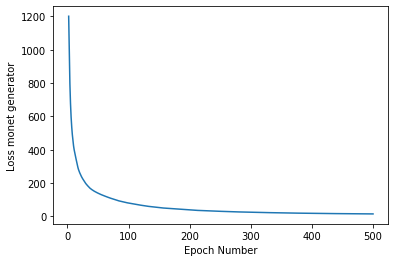

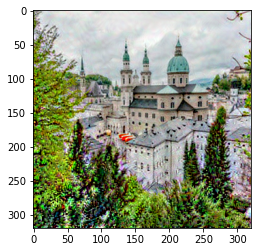

In [ ]:
#for 500 epochs with adam with lr=0.02
import numpy as np
model = VGGModel()
model.train(monet_train_ds)

import matplotlib.pyplot as plt
def visual_loss():
  plt.xlabel('Epoch Number')
  plt.ylabel("Loss monet generator")
  plt.plot(epoch_list[1:], loss_list[1:])
  plt.show()

for i, img in enumerate(photo_test_ds.take(1)):
    plt.imshow(img[0])
    plt.show()
    prediction = model.generate(img, True)[0].numpy()

    visual_loss()
    plt.imshow(prediction)
    plt.show()


###Experiment 3

1.   <b>epochs:</b> 500
2.   <b>optimizer:</b> SGD with momentum
3. <b>lr:</b> 0.02


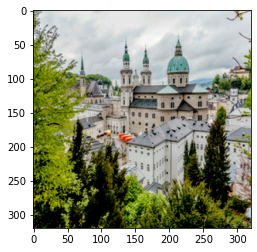

Iteration: 1, Total loss: 9.285735130310059
Iteration: 2, Total loss: 1201.540283203125
Iteration: 3, Total loss: 897.5361938476562
Iteration: 4, Total loss: 1211.47705078125
Iteration: 5, Total loss: 1301.638427734375
Iteration: 6, Total loss: 1703.867919921875
Iteration: 7, Total loss: 1244.11328125
Iteration: 8, Total loss: 1016.2022094726562
Iteration: 9, Total loss: 1007.7442016601562
Iteration: 10, Total loss: 940.6080322265625
Iteration: 11, Total loss: 755.9092407226562
Iteration: 12, Total loss: 887.2332153320312
Iteration: 13, Total loss: 648.0489501953125
Iteration: 14, Total loss: 517.7964477539062
Iteration: 15, Total loss: 413.60675048828125
Iteration: 16, Total loss: 380.7527160644531
Iteration: 17, Total loss: 348.5035095214844
Iteration: 18, Total loss: 321.9364929199219
Iteration: 19, Total loss: 269.13421630859375
Iteration: 20, Total loss: 244.57571411132812
Iteration: 21, Total loss: 238.97763061523438
Iteration: 22, Total loss: 240.05239868164062
Iteration: 23, To

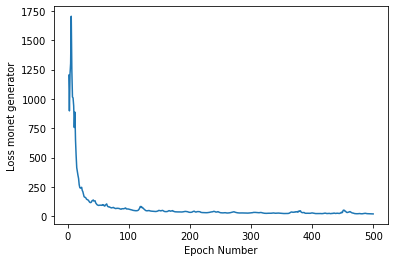

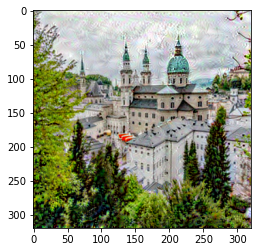

In [ ]:
#for 500 epochs with SGD and momentum with lr=0.02
import numpy as np
model = VGGModel()
model.train(monet_train_ds)

import matplotlib.pyplot as plt
def visual_loss():
  plt.xlabel('Epoch Number')
  plt.ylabel("Loss monet generator")
  plt.plot(epoch_list[1:], loss_list[1:])
  plt.show()

for i, img in enumerate(photo_test_ds.take(1)):
    plt.imshow(img[0])
    plt.show()
    prediction = model.generate(img, True)[0].numpy()

    visual_loss()
    plt.imshow(prediction)
    plt.show()

###Experiment 4

1.   <b>epochs:</b> 500
2.   <b>optimizer:</b> SGD with momentum
3. <b>lr:</b> 0.1


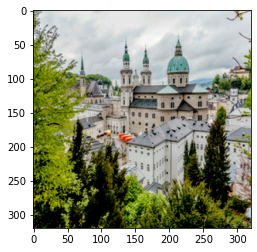

Iteration: 1, Total loss: 9.285735130310059
Iteration: 2, Total loss: 1202.216064453125
Iteration: 3, Total loss: 3151.4560546875
Iteration: 4, Total loss: 6393.57421875
Iteration: 5, Total loss: 6786.86328125
Iteration: 6, Total loss: 5567.7216796875
Iteration: 7, Total loss: 4776.251953125
Iteration: 8, Total loss: 3982.66064453125
Iteration: 9, Total loss: 3436.031982421875
Iteration: 10, Total loss: 3091.636474609375
Iteration: 11, Total loss: 2730.20947265625
Iteration: 12, Total loss: 2456.625
Iteration: 13, Total loss: 2289.75
Iteration: 14, Total loss: 2125.80224609375
Iteration: 15, Total loss: 2014.322509765625
Iteration: 16, Total loss: 1950.7701416015625
Iteration: 17, Total loss: 1895.0606689453125
Iteration: 18, Total loss: 1773.1617431640625
Iteration: 19, Total loss: 1721.110107421875
Iteration: 20, Total loss: 1680.130126953125
Iteration: 21, Total loss: 1645.084228515625
Iteration: 22, Total loss: 1627.5806884765625
Iteration: 23, Total loss: 1502.5711669921875
Iterat

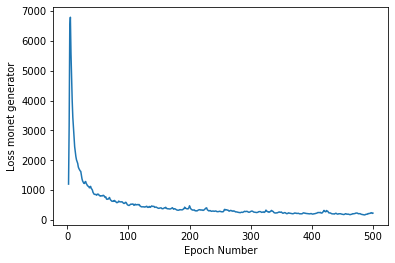

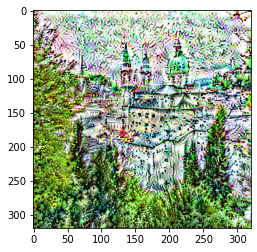

In [ ]:
#for 500 epochs with SGD and momentum and lr=0.1
import numpy as np
model = VGGModel()
model.train(monet_train_ds)

import matplotlib.pyplot as plt
def visual_loss():
  plt.xlabel('Epoch Number')
  plt.ylabel("Loss monet generator")
  plt.plot(epoch_list[1:], loss_list[1:])
  plt.show()

for i, img in enumerate(photo_test_ds.take(1)):
    plt.imshow(img[0])
    plt.show()
    prediction = model.generate(img, True)[0].numpy()

    visual_loss()
    plt.imshow(prediction)
    plt.show()

###Experiment 5

1.   <b>epochs:</b> 500
2.   <b>optimizer:</b> Adam
3. <b>lr:</b> 0.1


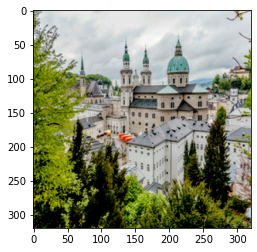

Iteration: 1, Total loss: 9.285735130310059
Iteration: 2, Total loss: 1201.60498046875
Iteration: 3, Total loss: 828.7340698242188
Iteration: 4, Total loss: 727.9300537109375
Iteration: 5, Total loss: 615.2862548828125
Iteration: 6, Total loss: 557.5272216796875
Iteration: 7, Total loss: 455.1058349609375
Iteration: 8, Total loss: 408.3669128417969
Iteration: 9, Total loss: 376.5771789550781
Iteration: 10, Total loss: 360.92169189453125
Iteration: 11, Total loss: 333.9902648925781
Iteration: 12, Total loss: 321.6229248046875
Iteration: 13, Total loss: 304.5534973144531
Iteration: 14, Total loss: 295.8781433105469
Iteration: 15, Total loss: 284.3387756347656
Iteration: 16, Total loss: 270.0674743652344
Iteration: 17, Total loss: 259.999267578125
Iteration: 18, Total loss: 254.26641845703125
Iteration: 19, Total loss: 250.85311889648438
Iteration: 20, Total loss: 245.70755004882812
Iteration: 21, Total loss: 239.84974670410156
Iteration: 22, Total loss: 232.44021606445312
Iteration: 23, 

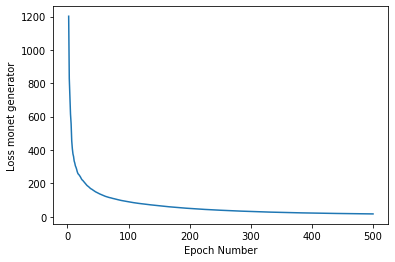

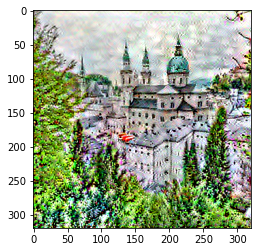

In [ ]:
#for 500 epochs with adam and lr=0.1
import numpy as np
model = VGGModel()
model.train(monet_train_ds)

import matplotlib.pyplot as plt
def visual_loss():
  plt.xlabel('Epoch Number')
  plt.ylabel("Loss monet generator")
  plt.plot(epoch_list[1:], loss_list[1:])
  plt.show()

for i, img in enumerate(photo_test_ds.take(1)):
    plt.imshow(img[0])
    plt.show()
    prediction = model.generate(img, True)[0].numpy()

    visual_loss()
    plt.imshow(prediction)
    plt.show()